## LATISS Spectrum FWHM

Craig Lage - 26-Feb-25

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
from lsst.ip.isr import IsrTask, IsrTaskConfig
from lsst.summit.utils.plotting import plot
import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.daf.butler import Butler
from scipy.optimize import curve_fit

In [2]:
butler = butlerUtils.makeDefaultButler("LATISS")
instrument = 'LATISS'

In [7]:
butler = Butler('/repo/LATISS', collections=["LATISS/raw/all", "LATISS/calib"])

## Define a simple ISR
### Just overscan subtraction and bias subtraction.
### An alternative is to get the postISRCDD image instead of the raw data, but the postISRCCD data is not always available.

In [3]:
isrConfig = IsrTaskConfig()
isrConfig.doLinearize=False
isrConfig.doOverscan=True
isrConfig.overscan.fitType="MEDIAN_PER_ROW"
isrConfig.overscan.doParallelOverscan=True
isrConfig.doAssembleCcd=True
isrConfig.doBias=False
isrConfig.doVariance=False
isrConfig.doCrosstalk=False
isrConfig.doBrighterFatter=False
isrConfig.doDark=False
isrConfig.doStrayLight=False
isrConfig.doFlat=False
isrConfig.doFringe=False
isrConfig.doApplyGains=True
isrConfig.doDefect=False
isrConfig.doNanMasking=True
isrConfig.doInterpolate=False
isrConfig.doSaturation=False
isrConfig.doSaturationInterpolation=False
isrTask = IsrTask(config=isrConfig)

## Run the ISR and look at the result

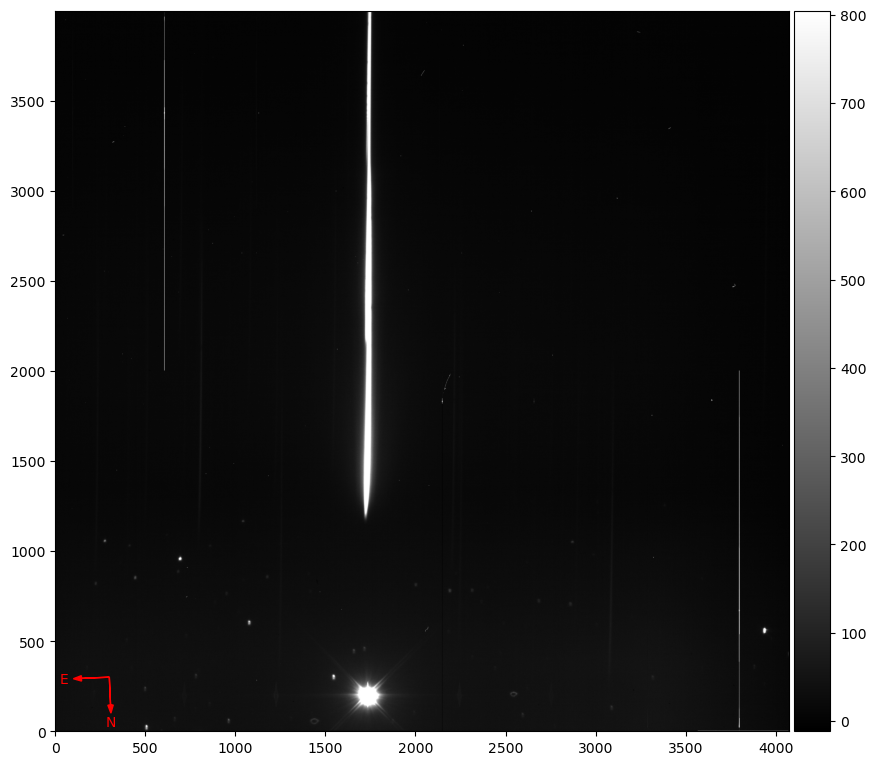

In [13]:
%matplotlib inline
expId = 2025031800424
#expId = 2025022500202
instrument='LATISS'
exp = butler.get('raw', detector=0, exposure=expId, instrument=instrument)
isrResult = isrTask.run(exp) # This runs the ISR
x = plot(isrResult.exposure, stretch='linear')

## Now plot the spectrum profile.  Since the spectrum is always in about the same place, we should not need to change x1, x2 and y.

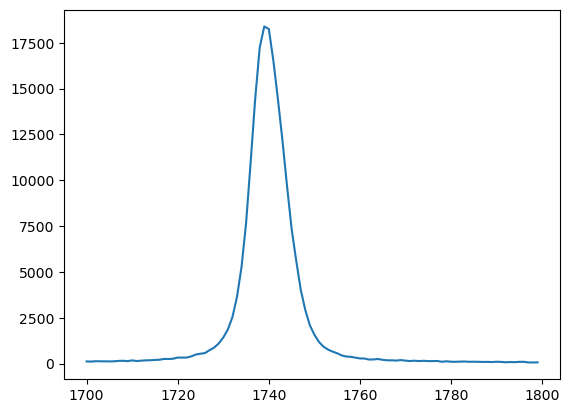

In [14]:
y = 2000
x1 = 1700
x2 = 1800
xs = list(range(x1, x2))
fluxes = isrResult.exposure.image.array[y, x1:x2]
plt.plot(xs, fluxes)

### Fitting a Gaussian to the spectrum profile.  This code came from DeepSeek.
### bg is the background level, A is the peak flux, mu is the Gaussian mean in pixels, sigma is the Gaussian sigma.

In [10]:
def gaussian(x, bg, A, mu, sigma):
    """
    Gaussian function
    """
    return bg + A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_gaussian(position_data, flux_data):
    """
    Fits a Gaussian curve to flux vs position data
    
    Args:
        position_data: 1D array of position values
        flux_data: 1D array of corresponding flux values
    
    Returns:
        Tuple of (A, mu, sigma) - optimal parameters for the Gaussian fit
    """
    # Calculate initial parameter guesses
    bg_guess = 0
    A_guess = np.max(flux_data)
    weighted_sum = np.sum(flux_data * position_data)
    total_flux = np.sum(flux_data)
    
    if total_flux == 0:
        raise ValueError("Total flux cannot be zero for fitting")
    
    mu_guess = weighted_sum / total_flux
    sigma_guess = np.sqrt(np.sum(flux_data * (position_data - mu_guess)**2) / total_flux)
    
    # Perform the curve fit
    params, _ = curve_fit(gaussian, 
                         position_data, 
                         flux_data, 
                         p0=[bg_guess, A_guess, mu_guess, sigma_guess])
    
    return tuple(params)

In [15]:
bg, A, mu, sigma = fit_gaussian(xs, fluxes)
print(bg, A, mu, sigma)

263.24737882555974 17713.182067688904 1739.7754256136404 3.8640084409676727


### Now plot it.

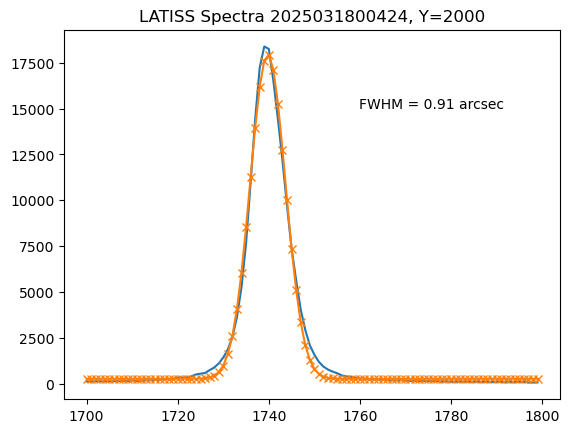

In [19]:
y_fit = gaussian(xs, bg, A, mu, sigma)
plt.plot(xs, fluxes)
plt.plot(xs, y_fit, marker='x')
plt.title(f"LATISS Spectra {expId}, Y={y}")
fwhm = sigma / 10.0 * 2.355
plt.text(mu+20, 15000, f"FWHM = {fwhm:.2f} arcsec")
plt.savefig(f'/home/cslage/DATA/Spectrum_FWHM_{expId}.png')